### 리뷰 데이터 전처리

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
data=pd.read_csv('tmp_data.csv',index_col=False)
data=data[['0','6','7']]
data.columns=['name','rating','reviews']
data.replace(0.5, 5.0, inplace=True)
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
data['label'] = data['rating'].apply(lambda x: 1 if float(x) > 3 else 0)
print(data.shape)
data.head()

(2362, 4)


,name,rating,reviews,label
0,홍대조폭떡볶이 홍대2호점,3.0,['전에 비하면 가격이 오르긴 했어도 다르곳에 비하면 저렴한 가격에 먹을수있음.'],0
1,홍대조폭떡볶이 홍대2호점,2.0,['다른분식집에 비해 맛이 너무없어서 실망스러웠습니다'],0
2,홍대조폭떡볶이 홍대2호점,4.0,['조폭떡볶이와 순대(내장x). 김밥이 먹고싶었는데 항상 저녁에 제일 먼저 떨어진다...,1
3,홍대조폭떡볶이 홍대2호점,5.0,[''],1
4,홍대조폭떡볶이 홍대2호점,5.0,['여기 직원분들 바뀌고나서 친절하셔서 너무 좋아요~떡볶이는 말할것도 없고 특히 순...,1


In [21]:

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [28]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
import pandas as pd

# 데이터프레임 로드
data['reviews'] = data['reviews'].apply(lambda x: text_cleaning(x))
# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다

#너무 짧은 리뷰는 삭제
data = data[data['reviews'].str.len() > 0]
data.head()

,name,rating,reviews,label
0,홍대조폭떡볶이 홍대2호점,3.0,전에 비하면 가격이 오르긴 했어도 다르곳에 비하면 저렴한 가격에 먹을수있음,0
1,홍대조폭떡볶이 홍대2호점,2.0,다른분식집에 비해 맛이 너무없어서 실망스러웠습니다,0
2,홍대조폭떡볶이 홍대2호점,4.0,조폭떡볶이와 순대내장 김밥이 먹고싶었는데 항상 저녁에 제일 먼저 떨어진다고 한다 떡...,1
4,홍대조폭떡볶이 홍대2호점,5.0,여기 직원분들 바뀌고나서 친절하셔서 너무 좋아요떡볶이는 말할것도 없고 특히 순대 와...,1
5,홍대조폭떡볶이 홍대2호점,2.0,다시 먹고 싶은 맛은 아니에요,0


In [29]:
data.to_csv("labeled_review_data.csv",index=False)

In [30]:
train_data, test_data = train_test_split(data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 1420
테스트용 리뷰의 개수 : 474


<Axes: xlabel='label'>

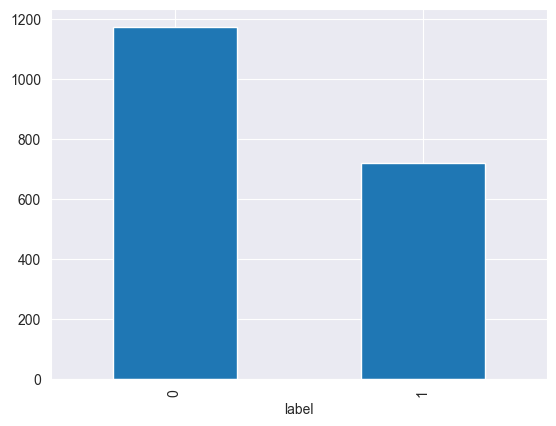

In [31]:
data['label'].value_counts().plot(kind = 'bar')


In [32]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

name       0
rating     0
reviews    0
label      0
dtype: int64


In [33]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 474


In [34]:
okt= Okt()

In [35]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


In [36]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [37]:
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [38]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [39]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 361), ('안', 206), ('너무', 180), ('만', 121), ('가격', 117), ('곳', 117), ('하고', 111), ('에서', 106), ('으로', 106), ('그', 103), ('그냥', 97), ('집', 96), ('로', 95), ('직원', 92), ('분', 92), ('진짜', 91), ('손님', 89), ('사람', 88), ('요', 83), ('초밥', 78)]


In [40]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛', 151), ('우동', 94), ('너무', 83), ('맛있어요', 79), ('곳', 57), ('잘', 52), ('튀김', 45), ('진짜', 45), ('가격', 45), ('집', 44), ('으로', 41), ('버거', 40), ('좀', 38), ('에서', 37), ('더', 36), ('하고', 36), ('요', 35), ('입니다', 35), ('수', 35), ('분', 34)]


In [41]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7807
등장 빈도가 1번 이하인 희귀 단어의 수: 4776
단어 집합에서 희귀 단어의 비율: 61.1758678109389
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.45231008153229


In [44]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3033


In [45]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [46]:
print(X_train[:3])


[[163, 1], [269, 138, 22, 26, 1997, 1490, 487, 13, 92, 99], [1207, 59, 1, 59, 50, 743, 59, 104, 1, 89, 377, 59, 329, 413, 1, 1, 222, 488, 1, 8, 1491, 594, 59, 1, 30]]


In [47]:
print(X_test[:3])


[[3, 2187, 30, 323, 6], [482, 1302, 70, 1082], [4, 547, 1]]


리뷰의 최대 길이 : 257
리뷰의 평균 길이 : 21.76619718309859


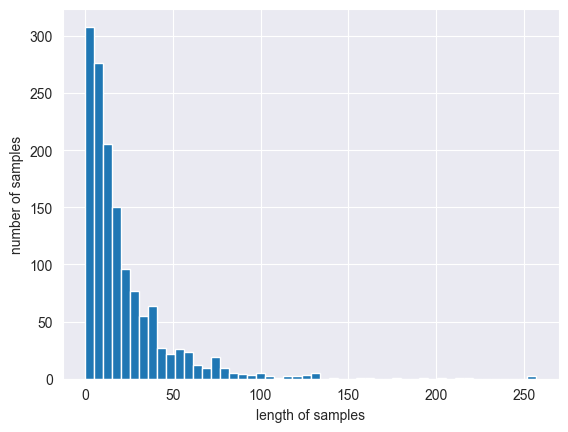

In [48]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [50]:
max_len = 300
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 100.0


In [51]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### BiLSTM

In [3]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [291]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_BiLSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - ETA: 0s - loss: 0.6782 - acc: 0.5951
Epoch 1: val_acc improved from -inf to 0.65141, saving model to best_model_BiLSTM.h5
5/5 [==============================] - 28s 5s/step - loss: 0.6782 - acc: 0.5951 - val_loss: 0.6485 - val_acc: 0.6514
Epoch 2/15


C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - ETA: 0s - loss: 0.6643 - acc: 0.6206
Epoch 2: val_acc did not improve from 0.65141
5/5 [==============================] - 23s 5s/step - loss: 0.6643 - acc: 0.6206 - val_loss: 0.6527 - val_acc: 0.6514
Epoch 3/15
5/5 [==============================] - ETA: 0s - loss: 0.6613 - acc: 0.6206
Epoch 3: val_acc did not improve from 0.65141
5/5 [==============================] - 24s 5s/step - loss: 0.6613 - acc: 0.6206 - val_loss: 0.6540 - val_acc: 0.6514
Epoch 4/15
5/5 [==============================] - ETA: 0s - loss: 0.6532 - acc: 0.6215
Epoch 4: val_acc did not improve from 0.65141
5/5 [==============================] - 24s 5s/step - loss: 0.6532 - acc: 0.6215 - val_loss: 0.6388 - val_acc: 0.6514
Epoch 5/15
5/5 [==============================] - ETA: 0s - loss: 0.6505 - acc: 0.6224
Epoch 5: val_acc did not improve from 0.65141
5/5 [==============================] - 25s 5s/step - loss: 0.6505 - acc: 0.6224 - val_loss: 0.6369 - val_acc: 0.6514
Epoch 6/15


### GRU

In [292]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_GRU.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.6685 - acc: 0.6127
Epoch 1: val_acc improved from -inf to 0.65141, saving model to best_model_GRU.h5
18/18 [==============================] - 21s 1s/step - loss: 0.6685 - acc: 0.6127 - val_loss: 0.6397 - val_acc: 0.6514
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 0.6400 - acc: 0.6232
Epoch 2: val_acc improved from 0.65141 to 0.65845, saving model to best_model_GRU.h5
18/18 [==============================] - 19s 1s/step - loss: 0.6400 - acc: 0.6232 - val_loss: 0.6217 - val_acc: 0.6585
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.5833 - acc: 0.6866
Epoch 3: val_acc improved from 0.65845 to 0.71479, saving model to best_model_GRU.h5
18/18 [==============================] - 18s 1s/step - loss: 0.5833 - acc: 0.6866 - val_loss: 0.5698 - val_acc: 0.7148
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 0.4722 - acc: 0.7817
Epoch 4: val_acc improved from 0.71

### LSTM

In [ ]:

# 모델 컴파일 및 학습
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
metrics = Metrics()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc, metrics], batch_size=64, validation_split=0.2)


In [317]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.6677 - acc: 0.6127
Epoch 1: val_acc improved from -inf to 0.64789, saving model to best_model_LSTM.h5
18/18 [==============================] - 28s 1s/step - loss: 0.6677 - acc: 0.6127 - val_loss: 0.6418 - val_acc: 0.6479
Epoch 2/15


C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 0.6422 - acc: 0.6312
Epoch 2: val_acc improved from 0.64789 to 0.65845, saving model to best_model_LSTM.h5
18/18 [==============================] - 32s 2s/step - loss: 0.6422 - acc: 0.6312 - val_loss: 0.6192 - val_acc: 0.6585
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.5995 - acc: 0.6778
Epoch 3: val_acc improved from 0.65845 to 0.69014, saving model to best_model_LSTM.h5
18/18 [==============================] - 32s 2s/step - loss: 0.5995 - acc: 0.6778 - val_loss: 0.5969 - val_acc: 0.6901
Epoch 4/15
18/18 [==============================] - ETA: 0s - loss: 0.5318 - acc: 0.7403
Epoch 4: val_acc improved from 0.69014 to 0.77113, saving model to best_model_LSTM.h5
18/18 [==============================] - 32s 2s/step - loss: 0.5318 - acc: 0.7403 - val_loss: 0.5400 - val_acc: 0.7711
Epoch 5/15
18/18 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.8283
Epoch 5: val_acc did not improve from 0.

15/15 [==============================] - 2s 124ms/step


C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-pa

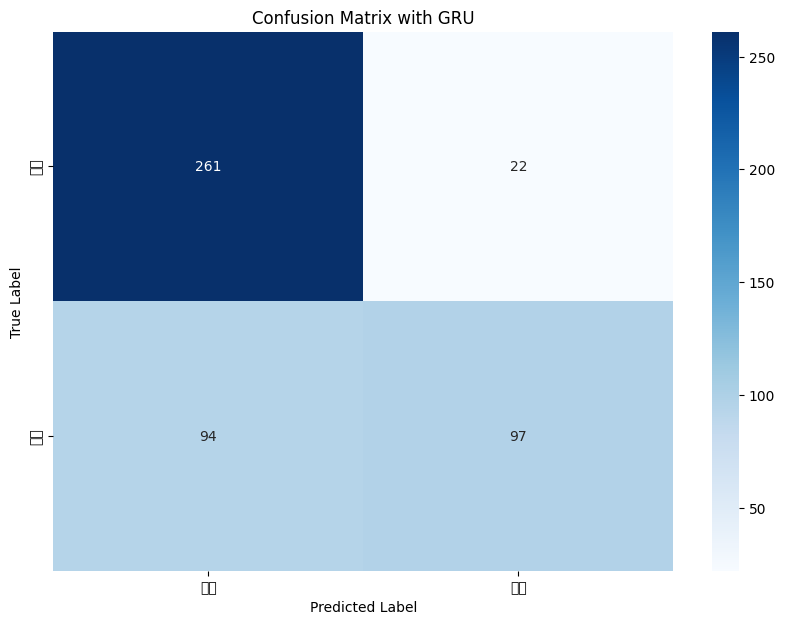

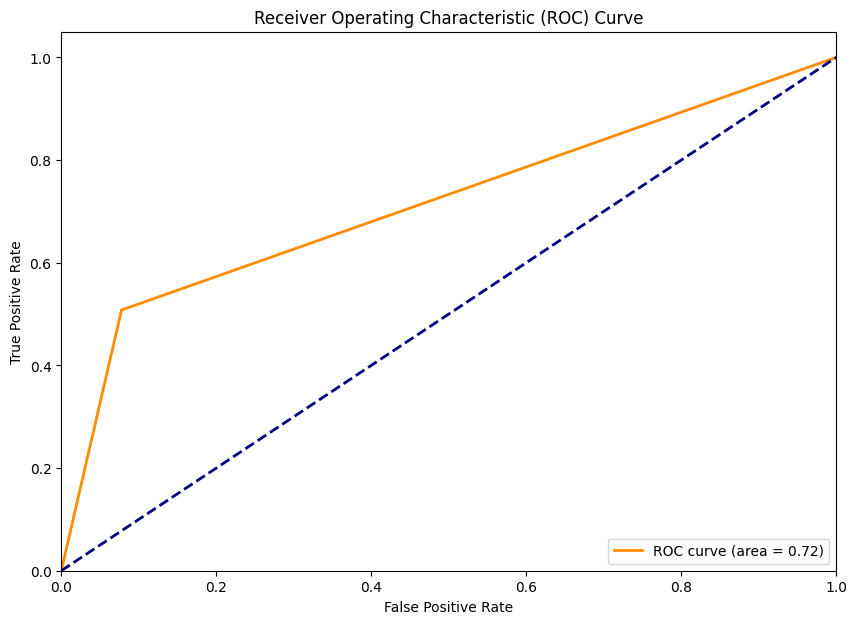

In [321]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import tensorflow as tf

model = load_model('best_model_GRU.h5')

# 검증 데이터에 대해 예측 수행
val_predict = (model.predict(X_test)).round()
val_targ = y_test

# Confusion Matrix 그리기
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with GRU')
    plt.show()

# ROC 커브 그리기
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 클래스 이름 정의 (이진 분류의 경우 예시)
class_names = ['부정', '긍정']

# Confusion Matrix 출력
plot_confusion_matrix(val_targ, val_predict, class_names)

# ROC 커브 출력
plot_roc_curve(val_targ, val_predict)

15/15 [==============================] - 6s 354ms/step


C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-pa

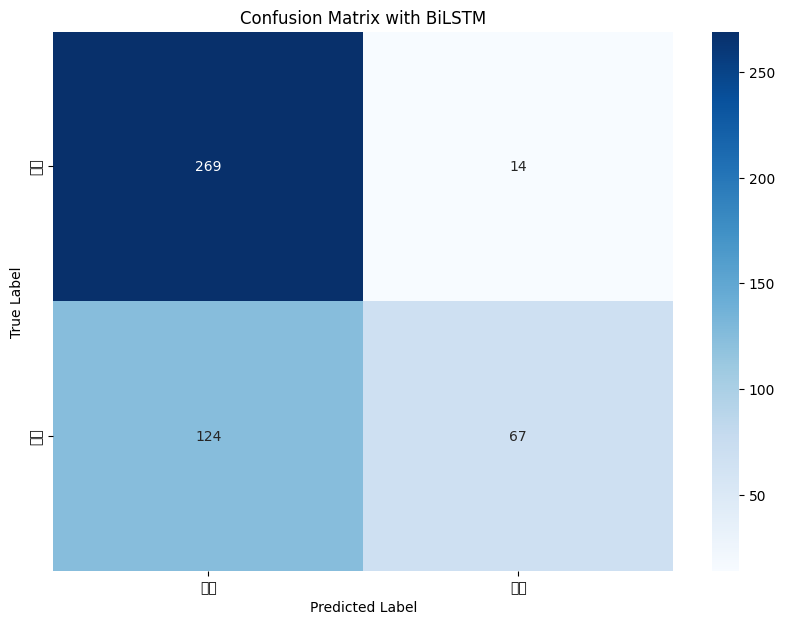

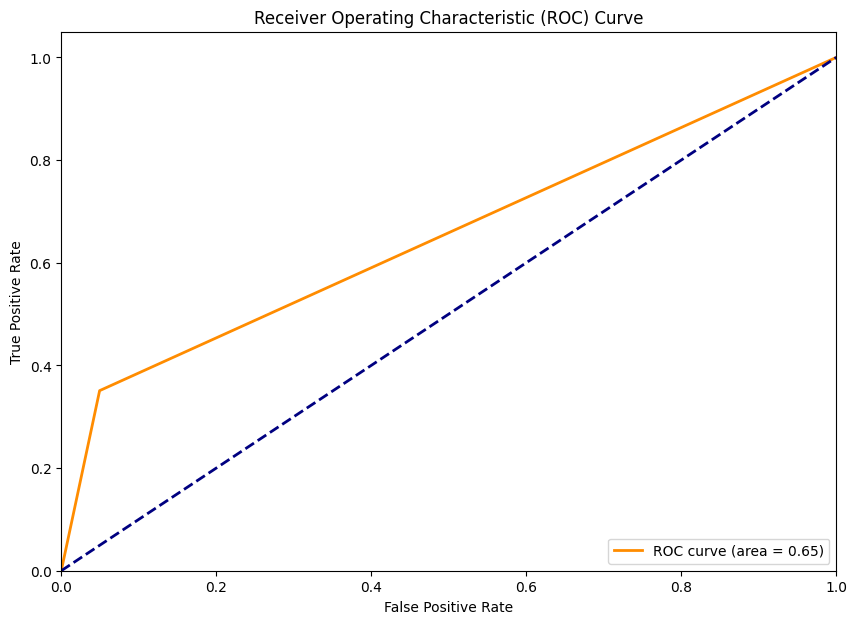

In [320]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import tensorflow as tf

model = load_model('best_model_BiLSTM.h5')

# 검증 데이터에 대해 예측 수행
val_predict = (model.predict(X_test)).round()
val_targ = y_test

# Confusion Matrix 그리기
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with BiLSTM')
    plt.show()

# ROC 커브 그리기
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 클래스 이름 정의 (이진 분류의 경우 예시)
class_names = ['부정', '긍정']

# Confusion Matrix 출력
plot_confusion_matrix(val_targ, val_predict, class_names)

# ROC 커브 출력
plot_roc_curve(val_targ, val_predict)

In [11]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import tensorflow as tf

15/15 [==============================] - 4s 180ms/step


C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.draw()
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AnTaeHyun\anaconda3\envs\text\lib\site-pa

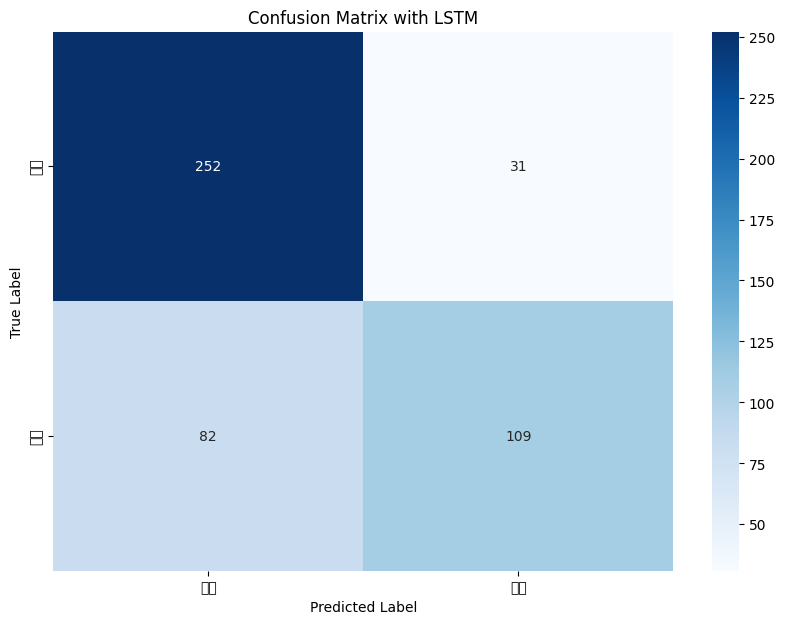

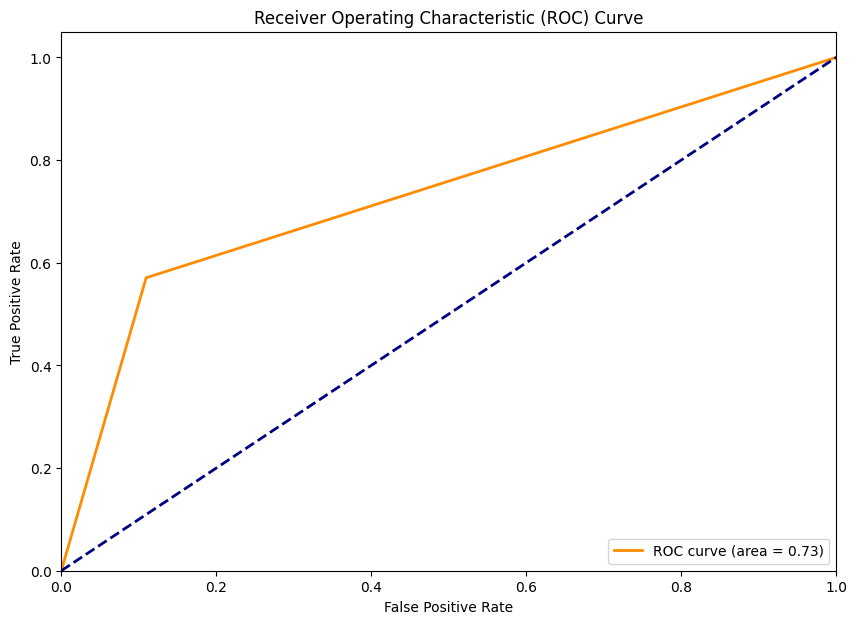

In [319]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import tensorflow as tf

model = load_model('best_model_LSTM.h5')

# 검증 데이터에 대해 예측 수행
val_predict = (model.predict(X_test)).round()
val_targ = y_test

# Confusion Matrix 그리기
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix with LSTM')
    plt.show()

# ROC 커브 그리기
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 클래스 이름 정의 (이진 분류의 경우 예시)
class_names = ['부정', '긍정']

# Confusion Matrix 출력
plot_confusion_matrix(val_targ, val_predict, class_names)

# ROC 커브 출력
plot_roc_curve(val_targ, val_predict)

In [58]:
loaded_model_BiLSTM = load_model('best_model_BiLSTM.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_BiLSTM.evaluate(X_test, y_test)[1]))
loaded_model_GRU = load_model('best_model_GRU.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_GRU.evaluate(X_test, y_test)[1]))
loaded_model_LSTM = load_model('best_model_LSTM.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_LSTM.evaluate(X_test, y_test)[1]))

15/15 [==============================] - 2s 76ms/step - loss: 0.5479 - acc: 0.7089

 테스트 정확도: 0.7089
15/15 [==============================] - 1s 43ms/step - loss: 0.8065 - acc: 0.7553

 테스트 정확도: 0.7553
15/15 [==============================] - 1s 62ms/step - loss: 0.5569 - acc: 0.7616

 테스트 정확도: 0.7616


### 실적용

In [59]:
pos_rev=[]
neg_rev=[]

In [60]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence_morp = okt.morphs(new_sentence)
  new_sentence_morp = [word for word in new_sentence_morp if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence_morp])
  pad_new = pad_sequences(encoded, maxlen = max_len)

# loaded_model_LSTM,loaded_model_GRU,loaded_model_BiLSTM
  score = float(loaded_model_LSTM.predict(pad_new))
 
  return score
  


In [83]:
our_data1=pd.read_csv('naver_final.csv',index_col=False)
our_data1['platform']='naver'
our_data2=pd.read_csv('kakao_final.csv',index_col=False)
our_data2['platform']='kakao'
our_data3=pd.read_csv('blog_final.csv',index_col=False)
our_data3['platform']='blog'


all_data_review_categorized=pd.concat([our_data1,our_data2,our_data3])



In [84]:
all_data_review_categorized

,review,category,restaurant,platform
0,마제소바 준비하신다고 테스트로 맛보여주셔서,맛,윤스쿡,naver
1,양도 많고 맛도 있어요,맛,윤스쿡,naver
2,양많고 맛나요,맛,윤스쿡,naver
3,학교앞 돈가스중 제일 맛있움ㅜ,맛,윤스쿡,naver
4,너무 맛나네요,맛,윤스쿡,naver
...,...,...,...,...
2477,서울특별시 중구 충무로5길 21 2층이 블로그의 체크인이 장소의 다른 글 취향로3가...,분위기,연어시장 석계본점,blog
2478,앤틱한 분위기의 찻집에 와봤는데,분위기,연어시장 석계본점,blog
2479,내부에 들어서자마자 디자인이나 인테리어가 기분이 좋아지는,분위기,연어시장 석계본점,blog
2480,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,분위기,연어시장 석계본점,blog


In [94]:
scores = []

In [95]:
rev=all_data_review_categorized['review']
for i in rev:
    score=sentiment_predict(i)
    scores.append(score)

1/1 [==============================] - 0s 28ms/step


In [96]:
all_data_review_categorized['sentiment_score'] = scores


In [97]:
all_data_review_categorized

,review,category,restaurant,platform,sentiment_score
0,마제소바 준비하신다고 테스트로 맛보여주셔서,맛,윤스쿡,naver,0.128197
1,양도 많고 맛도 있어요,맛,윤스쿡,naver,0.630403
2,양많고 맛나요,맛,윤스쿡,naver,0.663420
3,학교앞 돈가스중 제일 맛있움ㅜ,맛,윤스쿡,naver,0.189523
4,너무 맛나네요,맛,윤스쿡,naver,0.504508
...,...,...,...,...,...
2477,서울특별시 중구 충무로5길 21 2층이 블로그의 체크인이 장소의 다른 글 취향로3가...,분위기,연어시장 석계본점,blog,0.338766
2478,앤틱한 분위기의 찻집에 와봤는데,분위기,연어시장 석계본점,blog,0.440441
2479,내부에 들어서자마자 디자인이나 인테리어가 기분이 좋아지는,분위기,연어시장 석계본점,blog,0.437413
2480,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,분위기,연어시장 석계본점,blog,0.075812


In [315]:
all_data_review_categorized.to_csv("sentiment_score_data.csv",index=False)

In [114]:
all_data_review_categorized

,review,category,restaurant,platform,sentiment_score
0,마제소바 준비하신다고 테스트로 맛보여주셔서,맛,윤스쿡,naver,0.128197
1,양도 많고 맛도 있어요,맛,윤스쿡,naver,0.630403
2,양많고 맛나요,맛,윤스쿡,naver,0.663420
3,학교앞 돈가스중 제일 맛있움ㅜ,맛,윤스쿡,naver,0.189523
4,너무 맛나네요,맛,윤스쿡,naver,0.504508
...,...,...,...,...,...
2477,서울특별시 중구 충무로5길 21 2층이 블로그의 체크인이 장소의 다른 글 취향로3가...,분위기,연어시장 석계본점,blog,0.338766
2478,앤틱한 분위기의 찻집에 와봤는데,분위기,연어시장 석계본점,blog,0.440441
2479,내부에 들어서자마자 디자인이나 인테리어가 기분이 좋아지는,분위기,연어시장 석계본점,blog,0.437413
2480,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,분위기,연어시장 석계본점,blog,0.075812


In [100]:
all_data_review_categorized[all_data_review_categorized['platform']=='blog']

,review,category,restaurant,platform,sentiment_score
0,광운대맛집 광운대혼밥 광운대돈까스 광운대 맛집 뚝배기 쫄면순두부 학교종이땡땡땡 광운...,맛,윤스쿡,blog,0.465832
1,셋째주 토요일 휴무 무선 인터넷 서울특별시 노원구 광운로 29 2층윤스쿡은 광운대학...,맛,윤스쿡,blog,0.105630
2,마늘맛도 살짝 느껴지면서 시원해서,맛,윤스쿡,blog,0.372434
3,면발도 쫄깃하면서 탱글하니 맛도리,맛,윤스쿡,blog,0.527368
4,버리세요 광운대맛집 광운대역맛집 광운대밥집광운대돈까스맛집 광운대돈까스 광운대혼밥광운...,맛,윤스쿡,blog,0.342937
...,...,...,...,...,...
2477,서울특별시 중구 충무로5길 21 2층이 블로그의 체크인이 장소의 다른 글 취향로3가...,분위기,연어시장 석계본점,blog,0.338766
2478,앤틱한 분위기의 찻집에 와봤는데,분위기,연어시장 석계본점,blog,0.440441
2479,내부에 들어서자마자 디자인이나 인테리어가 기분이 좋아지는,분위기,연어시장 석계본점,blog,0.437413
2480,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,분위기,연어시장 석계본점,blog,0.075812


In [121]:
all_data_review_categorized=all_data_review_categorized.reset_index()

In [123]:
all_data_review_categorized=all_data_review_categorized.drop(columns=['index'])

In [124]:
all_data_review_categorized

,review,category,restaurant,platform,sentiment_score
0,마제소바 준비하신다고 테스트로 맛보여주셔서,맛,윤스쿡,naver,0.128197
1,양도 많고 맛도 있어요,맛,윤스쿡,naver,0.630403
2,양많고 맛나요,맛,윤스쿡,naver,0.663420
3,학교앞 돈가스중 제일 맛있움ㅜ,맛,윤스쿡,naver,0.189523
4,너무 맛나네요,맛,윤스쿡,naver,0.504508
...,...,...,...,...,...
3349,서울특별시 중구 충무로5길 21 2층이 블로그의 체크인이 장소의 다른 글 취향로3가...,분위기,연어시장 석계본점,blog,0.338766
3350,앤틱한 분위기의 찻집에 와봤는데,분위기,연어시장 석계본점,blog,0.440441
3351,내부에 들어서자마자 디자인이나 인테리어가 기분이 좋아지는,분위기,연어시장 석계본점,blog,0.437413
3352,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,분위기,연어시장 석계본점,blog,0.075812


In [125]:
long=len(all_data_review_categorized['review'])

In [126]:
long

3354

### NAVER Hyper-Clova 

In [127]:
import requests
import json

# API 정보
api_url = "https://naveropenapi.apigw.ntruss.com/sentiment-analysis/v1/analyze"
client_id = "8447al0f6v"  # 여기에 실제 Client ID를 입력하세요.
client_secret = "RmbR8VSPDl4J8DZoD54wv8pIxUFnbhHhGepWyuAj"  # 여기에 실제 Client Secret을 입력하세요.

# 결과를 저장할 리스트
results = []

# 각 리뷰에 대해 감정 분석 수행
for i in range(long):
    # HTTP 요청 헤더 설정
    headers = {
        "X-NCP-APIGW-API-KEY-ID": client_id,
        "X-NCP-APIGW-API-KEY": client_secret,
        "Content-Type": "application/json"
    }
    text=all_data_review_categorized['review'].iloc[i]
    # HTTP 요청 데이터 설정
    data = {
        "content": text
    }

    # POST 요청 보내기
    response = requests.post(api_url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        analysis_result = response.json()
        # 전체 리뷰에 대한 감정
        doc_sentiment = analysis_result['document']['sentiment']
        doc_confidence = analysis_result['document']['confidence']
        # 개별 문장에 대한 감정
        sentences = analysis_result['sentences']
        for sentence in sentences:
            results.append({
                'review': text,
                'sentence': sentence['content'],
                'overall_sentiment': doc_sentiment,
                'overall_confidence_neutral': doc_confidence['neutral'],
                'overall_confidence_positive': doc_confidence['positive'],
                'overall_confidence_negative': doc_confidence['negative'],
                'category':all_data_review_categorized['category'][i],
                'restaurant':all_data_review_categorized['restaurant'][i],
                'platform':all_data_review_categorized['platform'][i],
            })
    else:
        print(f"Error {response.status_code}: {response.text}")

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)

                                                 review  \
0                               마제소바 준비하신다고 테스트로 맛보여주셔서   
1                                          양도 많고 맛도 있어요   
2                                               양많고 맛나요   
3                                      학교앞 돈가스중 제일 맛있움ㅜ   
4                                               너무 맛나네요   
...                                                 ...   
3924           약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아   
3925  하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...   
3926  하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...   
3927  하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...   
3928  하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...   

                                      sentence overall_sentiment  \
0                      마제소바 준비하신다고 테스트로 맛보여주셔서           neutral   
1                                 양도 많고 맛도 있어요          positive   
2                                      양많고 맛나요          positive   
3                  

In [128]:
results_df

,review,sentence,overall_sentiment,overall_confidence_neutral,overall_confidence_positive,overall_confidence_negative,category,restaurant,platform
0,마제소바 준비하신다고 테스트로 맛보여주셔서,마제소바 준비하신다고 테스트로 맛보여주셔서,neutral,99.944370,0.041965,0.013671,맛,윤스쿡,naver
1,양도 많고 맛도 있어요,양도 많고 맛도 있어요,positive,0.000276,99.999405,0.000319,맛,윤스쿡,naver
2,양많고 맛나요,양많고 맛나요,positive,0.000720,99.998230,0.001053,맛,윤스쿡,naver
3,학교앞 돈가스중 제일 맛있움ㅜ,학교앞 돈가스중 제일 맛있움ㅜ,positive,0.034673,99.948555,0.016771,맛,윤스쿡,naver
4,너무 맛나네요,너무 맛나네요,positive,0.002503,99.993965,0.003530,맛,윤스쿡,naver
...,...,...,...,...,...,...,...,...,...
3924,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,negative,14.269722,0.013413,85.716866,분위기,연어시장 석계본점,blog
3925,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,하시고 가격 올리지 않기로 약속해여,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog
3926,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아먹었네요,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog
3927,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,여기는 갈때마다 좀 시끄럽더라구요,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog


In [129]:
tmp_positive=results_df[results_df['overall_sentiment']=='positive']
tmp_negative=results_df[results_df['overall_sentiment']=='negative']
tmp_neutral=results_df[results_df['overall_sentiment']=='neutral']


In [132]:
tmp_negative

,review,sentence,overall_sentiment,overall_confidence_neutral,overall_confidence_positive,overall_confidence_negative,category,restaurant,platform
20,기대만큼 엄청 맛잇진 않앗,기대만큼 엄청 맛잇진 않앗,negative,0.000361,0.000318,99.999320,맛,윤스쿡,naver
39,대학가치고 가격이 조금 있는것같아여,대학가치고 가격이 조금 있는것같아여,negative,0.001489,0.000453,99.998055,가격,윤스쿡,naver
44,넘 맛있는데 가격이 계속 올라서 슬퍼요,넘 맛있는데 가격이 계속 올라서 슬퍼요,negative,0.000303,0.000359,99.999340,가격,윤스쿡,naver
45,맛있는데 비싸,맛있는데 비싸,negative,0.031283,0.015270,99.953445,가격,윤스쿡,naver
46,비싸,비싸,negative,0.043949,0.018890,99.937164,가격,윤스쿡,naver
...,...,...,...,...,...,...,...,...,...
3924,약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아,negative,14.269722,0.013413,85.716866,분위기,연어시장 석계본점,blog
3925,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,하시고 가격 올리지 않기로 약속해여,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog
3926,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,맛 가격 분위기 서비스 위치 총점 4점분위기가 점수를 많이 깎아먹었네요,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog
3927,하시고 가격 올리지 않기로 약속해여 맛 가격 분위기 서비스 위치 총점 4점분위기가 ...,여기는 갈때마다 좀 시끄럽더라구요,negative,5.247726,0.006209,94.746060,분위기,연어시장 석계본점,blog


In [133]:
tmp_positive=tmp_positive[['review','overall_sentiment','overall_confidence_positive','category','restaurant','platform']]
tmp_negative=tmp_negative[['review','overall_sentiment','overall_confidence_positive','category','restaurant','platform']]
tmp_neutral=tmp_neutral[['review','overall_sentiment','overall_confidence_neutral','category','restaurant','platform']]


In [134]:
tmp_positive.columns=['review','label','positivity','category','restaurant','platform']
tmp_negative.columns=['review','label','positivity','category','restaurant','platform']
tmp_neutral.columns=['review','label','positivity','category','restaurant','platform']
tmp_neutral['positivity']=tmp_neutral['positivity']*0.5

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_30100\3502571131.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_neutral['positivity']=tmp_neutral['positivity']*0.5


In [138]:
rating_all=pd.concat([tmp_positive,tmp_neutral,tmp_negative])

In [141]:
grouped_df = rating_all.groupby(['restaurant', 'category', 'platform'])['positivity'].mean().reset_index()


In [140]:
rating_all.to_csv("clova_sent.csv",index=False)

In [143]:
grouped_df.to_csv("clova_sent_rating.csv",index=False)